In [1]:
import torch
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import crop
import os
import cv2
import random
import scipy
import skimage
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch.optim as optim
from Model import *
from Prepare import preprocessing

In [2]:
cropped_size = 64
output_size = 128
expand_size = (output_size - cropped_size) // 2

### Preprocessing

In [3]:
preprocessing(cropped_size, output_size, expand_size)
preprocessing(cropped_size, output_size, expand_size, target_dir='val')

4500it [00:03, 1359.48it/s]


### Declare

In [3]:
gen = Generator()
dis = Discriminator()

gpu_device = torch.device('cuda:0')
cpu_device = torch.device("cpu")
gen.to(gpu_device)
dis.to(gpu_device)

Discriminator(
  (lrelu): LeakyReLU(negative_slope=0.2)
  (inorm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=1536, out_features=1, bias=True)
)

In [4]:
SSIM_MODULE = SSIM(data_range=1, size_average=True, channel=3)
Loss_L1 = nn.L1Loss()
optimizer_G = optim.Adam(gen.parameters(), lr=3e-4, betas=(0.5, 0.999))

Loss_BCE = nn.BCELoss()
optimizer_D = optim.Adam(dis.parameters(), lr=3e-4, betas=(0.5, 0.999))

trainset = OutpaintingDataset('./dataset/train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=4)

### Load Model

In [7]:
checkpoint_G = torch.load('model/gen_model-3-120.tar')
gen.load_state_dict(checkpoint_G['model_state_dict'])
optimizer_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
epoch = checkpoint_G['epoch']
loss_pxl = checkpoint_G['loss_pxl']
loss_ssim = checkpoint_G['loss_ssim']
loss_adv = checkpoint_G['loss_adv']
loss_pxl_array = checkpoint_G['loss_pxl_array']
loss_adv_array = checkpoint_G['loss_adv_array']

In [8]:
checkpoint_D = torch.load('model/dis_model-3-120.tar')
dis.load_state_dict(checkpoint_D['model_state_dict'])
optimizer_D.load_state_dict(checkpoint_D['optimizer_state_dict'])
epoch = checkpoint_D['epoch']
loss_D = checkpoint_D['loss']
loss_D_array = checkpoint_D['loss_D_array']

### Train

In [9]:
try: epoch
except: epoch = 1

try: loss_pxl_array
except: epoch = []

try: loss_ssim_array
except: loss_ssim_array = []

try: loss_adv_array
except: loss_adv_array = []

try: loss_D_array
except: loss_D_array = []

In [ ]:
Tensor = torch.cuda.FloatTensor

n = 1000
alpha_adv = 0.0004
alpha_ssim = 0.4998
alpha_pxl = 0.4998


while epoch <= 130:
    
    running_loss_pxl = 0.0
    running_loss_ssim = 0.0
    running_loss_adv = 0.0
    running_loss_D = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # dataset input
        inputs, gt = data
        inputs = inputs.to(gpu_device)
        gt = gt.to(gpu_device)
        gt_cr = crop(gt, 0, expand_size, output_size, cropped_size)
        # grad to zero
        optimizer_G.zero_grad()
        ###-----------###
        ### GENERATOR ###
        ###-----------###
        outputs = gen(inputs)
        
        valid = torch.ones(outputs.shape[0],1).to(gpu_device)
        fake = torch.zeros(outputs.shape[0],1).to(gpu_device)
        
        loss_ssim = 1 - SSIM_MODULE(crop(outputs, 0, expand_size, output_size, cropped_size), gt_cr) # лосс структурный
        loss_pxl = Loss_L1(crop(outputs, 0, expand_size, output_size, cropped_size), gt_cr) # лосс пиксельный
        loss_adv = Loss_BCE(dis(outputs), valid) # лосс от дискриминатора
        loss_G = alpha_pxl * loss_pxl + alpha_ssim * loss_ssim + alpha_adv * loss_adv
        
        # шажок генератора
        loss_G.backward()
        optimizer_G.step()
        
        ###---------------###
        ### ДИСКРИМИНАТОР ###
        ###---------------###
        
        #
        optimizer_D.zero_grad()
        
        loss_valid = Loss_BCE(dis(gt), valid)
        loss_fake = Loss_BCE(dis(outputs.detach()), fake)
        loss_D = loss_valid + loss_fake
        
        loss_D.backward()
        optimizer_D.step()
        
        ###-------------###
        ### ЛОГИРОВАНИЕ ###
        ###-------------###
        
        running_loss_pxl += loss_pxl.item()
        running_loss_ssim += loss_ssim.item()
        running_loss_adv += loss_adv.item()
        running_loss_D += loss_D.item()
        
        if i % n == n-1:
            print(f'[{epoch}, {i + 1:5d}] loss_pxl: {running_loss_pxl / n:.4f} loss_ssim: {running_loss_ssim / n:.3f} loss_adv: {running_loss_adv / n:.3f} loss_D: {running_loss_D / n:.3f}')
            loss_pxl_array.append(running_loss_pxl / n)
            loss_ssim_array.append(running_loss_ssim / n)
            loss_adv_array.append(running_loss_adv / n)
            loss_D_array.append(running_loss_D / n)
            
            running_loss_pxl = 0.0
            running_loss_ssim = 0.0
            running_loss_adv = 0.0
            running_loss_D = 0.0
            
            
            
            
            
            
    in_img = transforms.ToPILImage()(torch.squeeze(inputs[0], 0).to(cpu_device))
    gen_img = transforms.ToPILImage()(torch.squeeze(gen(inputs)[0], 0).to(cpu_device))
    gt_img = transforms.ToPILImage()(torch.squeeze(gt[0], 0).to(cpu_device))
            
    fig, axarr = plt.subplots(1,3,figsize=(18,6))
    axarr[0].imshow(in_img)
    axarr[1].imshow(gen_img)
    axarr[2].imshow(gt_img)
            
    fig.savefig('epoch ' + str(epoch).zfill(3) + '.jpg', dpi=50)
    
    
    epoch += 1

print('Done')

### Save

In [33]:
torch.save({
            'epoch': epoch,
            'model_state_dict': gen.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'loss_pxl': loss_pxl,
            'loss_ssim': loss_ssim,
            'loss_adv': loss_adv,
            'loss_pxl_array': loss_pxl_array,
            'loss_adv_array': loss_adv_array,
            }, 'gen_model-'+str(epoch).zfill(3)+'.tar')
torch.save({
            'epoch': epoch,
            'model_state_dict': dis.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'loss': loss_D,
            'loss_D_array': loss_D_array,
            }, 'dis_model-'+str(epoch).zfill(3)+'.tar')

### Show

In [6]:
input_img = cv2.imread('badlands00002009.jpg')
if not False:
    input_img = cv2.copyMakeBorder(
        input_img,
        top=0, 
        bottom=0, 
        left=expand_size, 
        right=expand_size, 
        borderType=cv2.BORDER_CONSTANT,  
        value=0
    )

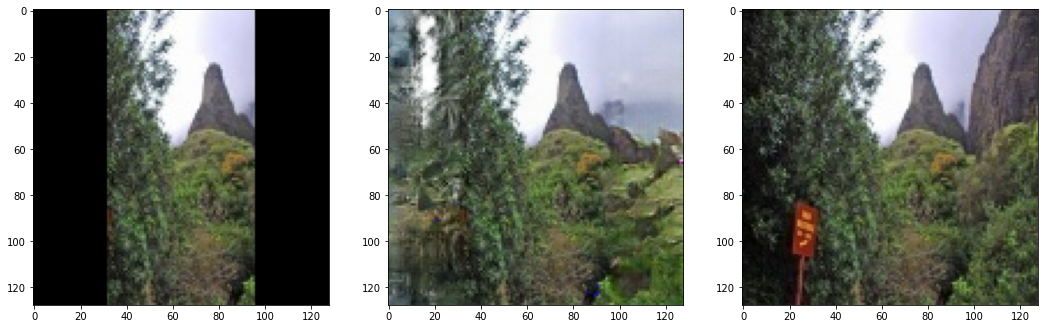

In [31]:
img_name =  random.choice(os.listdir('dataset/val/cropped')) # 'badlands00000002.jpg'
cropped_img_path = 'dataset/val/cropped/'+img_name
gt_img_path = 'dataset/val/gt/'+img_name

in_img = Image.open(cropped_img_path)
gen_img = transforms.ToTensor()(in_img)
gen_img = torch.unsqueeze(gen_img,0).to(gpu_device)
gen_img = gen(gen_img).to(cpu_device)
gen_img = torch.squeeze(gen_img,0)
gen_img = transforms.ToPILImage()(gen_img)
gt_img = Image.open(gt_img_path)
        
fig, axarr = plt.subplots(1,3,figsize=(18,6))
axarr[0].imshow(in_img)
axarr[1].imshow(gen_img)
axarr[2].imshow(gt_img)

fig.savefig('test2.jpg', dpi=50)

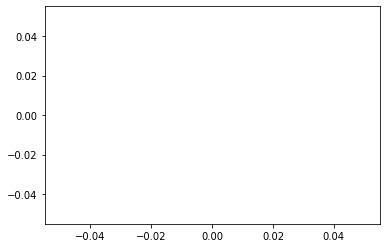

In [32]:
plt.scatter(range(len(loss_ssim_array)), loss_ssim_array)
plt.show()